## Fruit trait prediction from image inputs

Input is an image and output is a multi scalar regression vector for the predicted fruit traits
these traits are measurements of the fruit.

The data is standardized

In [1]:
from fastai.vision.all import *

In [19]:
from fastcore.basics import Int
from fastcore.transform import DisplayedTransform
from fastcore.xtras import Path

from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import fine_tune

from fastai.data.block import DataBlock, RegressionBlock
from fastai.data.transforms import RandomSplitter, get_image_files, ColReader

from fastai.losses import MSELossFlat

from fastai.torch_core import ShowTitle, show_title, TitledFloat

from fastai.vision.augment import Resize, aug_transforms, Flip, Rotate, Zoom, Warp
from fastai.vision.data import ImageBlock
from fastai.vision.learner import cnn_learner

from torchvision.models.resnet import resnet50

from datetime import datetime, timedelta


import pandas as pd
from scipy.io import loadmat
import numpy as np

from scipy.io import loadmat
from datetime import datetime, timedelta

from fastai.metrics import mae, rmse, R2Score
from sklearn.model_selection import train_test_split

In [3]:
n_out_val      = 12
img_resize_val = 150

In [4]:
path = 'fruits/'

In [5]:
AllData = pd.read_csv(path +'PhenotypeDataUGA.csv')

In [6]:
AllData

,line,photo_id,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio
0,147,6742,84.32,16.80,31.41,87.67,17.61,32.41,101.6,112.0,90.94,0.19,1.09,0.2
1,132,6744,75.96,18.63,25.27,82.09,19.57,26.66,118.3,122.7,73.39,0.18,0.93,0.2
2,20,6745,69.47,18.00,23.02,73.99,18.98,24.28,124.0,136.9,65.64,0.18,0.92,0.2
3,83,6746,74.58,14.73,27.44,80.63,15.52,28.92,108.6,101.7,63.50,0.18,0.81,0.2
4,119,6748,79.19,15.29,30.22,84.72,16.08,31.85,100.5,88.6,73.25,0.18,0.90,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,453,7714,79.37,16.03,22.55,85.12,16.89,31.21,96.8,105.8,76.44,0.18,0.93,0.2
291,677,7722,54.35,15.63,16.64,58.76,16.44,17.33,144.5,139.6,48.75,0.21,0.87,0.2
292,1410,7723,49.77,14.02,15.43,57.10,14.79,16.22,138.5,143.7,37.69,0.20,0.69,0.2
293,1434,7727,67.71,18.25,22.06,73.26,19.23,23.25,145.2,126.5,69.12,0.20,0.98,0.2


## Standardize the traits in the pandas dataframe ( [2:14] )

In [7]:

## df.iloc[:, 0:3]   ## example


y_means      = AllData.iloc[:, 2:14].mean()
y_deviations = AllData.iloc[:, 2:14].std()




In [8]:
y_means

perimeter1_cm                 75.753559
width1_cm                     18.553390
heigth1_cm                    25.259797
perimeter2_cm                 79.709186
width2_cm                     19.539322
heigth2_cm                    26.717593
prox_angl_macr               124.682373
distal_angl_macr             123.686102
tomat_pericap_area            79.054915
tomat_pericap_area_ratio       0.185288
tomat_pericap_thick            1.020000
tomat_pericap_thick_ratio      0.200102
dtype: float64

In [9]:
y_deviations

perimeter1_cm                10.012201
width1_cm                     2.579065
heigth1_cm                    4.272636
perimeter2_cm                 9.814579
width2_cm                     2.687700
heigth2_cm                    4.339802
prox_angl_macr               14.715583
distal_angl_macr             18.939076
tomat_pericap_area           23.384338
tomat_pericap_area_ratio      0.025724
tomat_pericap_thick           0.219342
tomat_pericap_thick_ratio     0.001300
dtype: float64

In [ ]:

## normalized_df=(df-df.min())/(df.max()-df.min())


In [10]:
AllData.iloc[:, 2:14] = ( AllData.iloc[:, 2:14] - y_means ) / y_deviations

In [11]:
AllData

,line,photo_id,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio
0,147,6742,0.855600,-0.679855,1.439440,0.811121,-0.717834,1.311674,-1.568567,-0.617037,0.508250,0.183168,0.319136,-0.07822
1,132,6744,0.020619,0.029705,0.002388,0.242579,0.011414,-0.013271,-0.433715,-0.052067,-0.242253,-0.205570,-0.410318,-0.07822
2,20,6745,-0.627590,-0.214570,-0.524219,-0.582724,-0.208104,-0.561683,-0.046371,0.697706,-0.573671,-0.205570,-0.455909,-0.07822
3,83,6746,-0.117213,-1.482471,0.510271,0.093821,-1.495450,0.507490,-1.092880,-1.160886,-0.665185,-0.205570,-0.957409,-0.07822
4,119,6748,0.343225,-1.265338,1.160923,0.510548,-1.287094,1.182636,-1.643317,-1.852577,-0.248239,-0.205570,-0.547091,-0.07822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,453,7714,0.361203,-0.978413,-0.634221,0.551304,-0.985721,1.035164,-1.894751,-0.944402,-0.111823,-0.205570,-0.410318,-0.07822
291,677,7722,-2.137748,-1.133508,-2.017442,-2.134497,-1.153150,-2.163139,1.346710,0.840268,-1.295949,0.960645,-0.683864,-0.07822
292,1410,7723,-2.595190,-1.757765,-2.300640,-2.303633,-1.767058,-2.418911,0.938979,1.056752,-1.768915,0.571907,-1.504500,-0.07822
293,1434,7727,-0.803376,-0.117636,-0.748904,-0.657103,-0.115088,-0.799021,1.394279,0.148576,-0.424853,0.571907,-0.182364,-0.07822



## Create DataLoader

We need to create a tuple of (x,y) for our model to train on. So we'll create it like this

(image_id, [column names])

Let's create a new column combined which is a list of the dependent variables.

In [12]:
headers_list = AllData.columns.values.tolist()
print(headers_list)
print(len(headers_list))


for i, name in enumerate(headers_list):
    print((i, name))

['line', 'photo_id', 'perimeter1_cm', 'width1_cm', 'heigth1_cm', 'perimeter2_cm', 'width2_cm', 'heigth2_cm', 'prox_angl_macr', 'distal_angl_macr', 'tomat_pericap_area', 'tomat_pericap_area_ratio', 'tomat_pericap_thick', 'tomat_pericap_thick_ratio']
14
(0, 'line')
(1, 'photo_id')
(2, 'perimeter1_cm')
(3, 'width1_cm')
(4, 'heigth1_cm')
(5, 'perimeter2_cm')
(6, 'width2_cm')
(7, 'heigth2_cm')
(8, 'prox_angl_macr')
(9, 'distal_angl_macr')
(10, 'tomat_pericap_area')
(11, 'tomat_pericap_area_ratio')
(12, 'tomat_pericap_thick')
(13, 'tomat_pericap_thick_ratio')


In [13]:
list_of_traits = [ 'perimeter1_cm','width1_cm','heigth1_cm','perimeter2_cm','width2_cm', 
                  'heigth2_cm','prox_angl_macr','distal_angl_macr','tomat_pericap_area', 
                  'tomat_pericap_area_ratio', 'tomat_pericap_thick','tomat_pericap_thick_ratio' ]

AllData['combined'] = AllData[ list_of_traits ].values.tolist()

In [14]:
AllData

,line,photo_id,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio,combined
0,147,6742,0.855600,-0.679855,1.439440,0.811121,-0.717834,1.311674,-1.568567,-0.617037,0.508250,0.183168,0.319136,-0.07822,"[0.8556001570706825, -0.6798548454527973, 1.4394399212641362, 0.8111212774804382, -0.7178337696244309, 1.31167441807962, -1.5685666144189667, -0.6170365140707609, 0.5082497928177809, 0.18316827877113348, 0.31913642081116506, -0.07821984063462172]"
1,132,6744,0.020619,0.029705,0.002388,0.242579,0.011414,-0.013271,-0.433715,-0.052067,-0.242253,-0.205570,-0.410318,-0.07822,"[0.02061891083281533, 0.029704629303495104, 0.0023880782021850613, 0.24257929435097725, 0.011414206474745139, -0.013270933841795108, -0.4337152455653336, -0.0520670423922915, -0.2422525430727678, -0.20557015459206263, -0.4103182553286403, -0.07821984063462172]"
2,20,6745,-0.627590,-0.214570,-0.524219,-0.582724,-0.208104,-0.561683,-0.046371,0.697706,-0.573671,-0.205570,-0.455909,-0.07822,"[-0.6275902145360548, -0.21456994397326115, -0.5242188675452725, -0.5827235843853381, -0.20810431694286383, -0.5616830968979636, -0.04637076637577007, 0.6977055274987612, -0.5736709535087652, -0.20557015459206263, -0.4559091725873782, -0.07821984063462172]"
3,83,6746,-0.117213,-1.482471,0.510271,0.093821,-1.495450,0.507490,-1.092880,-1.160886,-0.665185,-0.205570,-0.957409,-0.07822,"[-0.1172129216801336, -1.4824713005049979, 0.5102712214341779, 0.09382099768986295, -1.4954502339342661, 0.5074901957829705, -1.0928804119054678, -1.1608856316677918, -0.6651851984549632, -0.20557015459206263, -0.9574092624334942, -0.07821984063462172]"
4,119,6748,0.343225,-1.265338,1.160923,0.510548,-1.287094,1.182636,-1.643317,-1.852577,-0.248239,-0.205570,-0.547091,-0.07822,"[0.34322530142471896, -1.2653383464812147, 1.1609233588465915, 0.5105480068295579, -1.287093669334502, 1.182636262066405, -1.6433173033853732, -1.85257722783489, -0.24823945629354716, -0.20557015459206263, -0.5470910071048539, -0.07821984063462172]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,453,7714,0.361203,-0.978413,-0.634221,0.551304,-0.985721,1.035164,-1.894751,-0.944402,-0.111823,-0.205570,-0.410318,-0.07822,"[0.3612033665351044, -0.9784126572354997, -0.6342212073236301, 0.551303704544932, -0.9857207812526991, 1.0351640837655864, -1.8947514389996514, -0.9444020023330515, -0.11182336219150445, -0.20557015459206263, -0.4103182553286403, -0.07821984063462172]"
291,677,7722,-2.137748,-1.133508,-2.017442,-2.134497,-1.153150,-2.163139,1.346710,0.840268,-1.295949,0.960645,-0.683864,-0.07822,"[-2.1377476838083695, -1.1335076243953452, -2.017442118153619, -2.134496774898186, -1.1531501635203667, -2.163138783133415, 1.3467102552709052, 0.8402679175484679, -1.295949269929926, 0.9606451454975246, -0.6838637588810675, -0.07821984063462172]"
292,1410,7723,-2.595190,-1.757765,-2.300640,-2.303633,-1.767058,-2.418911,0.938979,1.056752,-1.768915,0.571907,-1.504500,-0.07822,"[-2.595189562728158, -1.7577648672137238, -2.3006396312000295, -2.303632920416986, -1.7670578985018164, -2.4189108423738968, 0.9389792245450489, 1.056751546883208, -1.7689154143714914, 0.5719067121343295, -1.5045002695383485, -0.07821984063462172]"
293,1434,7727,-0.803376,-0.117636,-0.748904,-0.657103,-0.115088,-0.799021,1.394279,0.148576,-0.424853,0.571907,-0.182364,-0.07822,"[-0.8033757400598168, -0.11763558949835771, -0.7489044977308547, -0.6571027327158938, -0.1150879934608261, -0.7990211338508436, 1.3942788755222542, 0.1485763213813703, -0.4248533963065365, 0.5719067121343295, -0.18236366903495146, -0.07821984063462172]"


## Split data train and test

In [20]:

train, test = train_test_split(AllData, test_size=0.3)


In [21]:
print(  len(test)  )

print(  len(train) )

89
206


In [22]:
train

,line,photo_id,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio,combined
58,580,6841,1.866367,1.379031,1.970728,1.935979,1.380614,1.832436,-0.107530,-0.928562,1.993860,0.183168,1.413318,-0.078220,"[1.8663669288323117, 1.379030843594151, 1.97072781764046, 1.9359785344247475, 1.3806144881303402, 1.8324355477043865, -0.10753042098464888, -0.9285617367719731, 1.9938595448883039, 0.18316827877113348, 1.413318435020873, -0.07821984063462172]"
21,478,6777,0.814650,-0.710874,1.598592,0.817235,-0.736437,1.620444,-1.602544,-2.839954,-0.631402,-1.760524,-1.185364,-0.078220,"[0.8146501198748066, -0.7108738388847672, 1.5985922426455907, 0.8172346321377445, -0.7364370343208387, 1.6204442913969597, -1.602544200312788, -2.8399537811421207, -0.6314019024234225, -1.7605238880448448, -1.1853638487271836, -0.07821984063462172]"
241,105,7389,0.279303,1.103737,-0.102933,0.236466,1.101566,-0.135396,0.687545,0.444261,0.097291,-0.205570,0.045591,-0.078220,"[0.2793032921433511, 1.103737276885425, -0.10293331094730629, 0.23646593969367097, 1.1015655176842272, -0.13539633149716068, 0.6875450889307717, 0.44426127852150343, 0.09729096387714424, -0.20557015459206263, 0.045590917258737866, -0.07821984063462172]"
75,796,6868,-0.047298,0.161535,-0.060805,-0.093655,0.134196,-0.167656,0.918593,-0.052067,-0.178107,-0.205570,-0.136773,-0.078220,"[-0.047298224028637245, 0.1615353513893637, -0.06080475528750975, -0.09365521180085432, 0.1341957534710343, -0.16765587050046485, 0.9185926730087554, -0.0520670423922915, -0.1781070442787038, -0.20557015459206263, -0.1367727517762136, -0.07821984063462172]"
256,869,7412,-0.877286,0.192554,-1.106997,-0.985186,0.167682,-1.248350,1.469030,0.555143,-0.593770,0.571907,-0.227955,-0.078220,"[-0.8772855632913978, 0.19255434482133352, -1.1069972208391252, -0.9851860993246508, 0.1676816299245678, -1.2483504271111499, 1.4690295644886626, 0.5551431374490532, -0.5937698764642385, 0.5719067121343295, -0.22795458629368934, -0.07821984063462172]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,750,6930,1.146246,-0.187428,1.785830,1.219697,-0.196942,1.818610,-1.840387,-2.211623,0.887136,0.183168,0.547091,-0.078220,"[1.146245543021903, -0.1874283247202881, 1.7858302678002416, 1.2196971470770586, -0.19694235812501887, 1.8186100309886843, -1.8403873015695376, -2.211623247219338, 0.8871358723613857, 0.18316827877113348, 0.5470910071048534, -0.07821984063462172]"
49,805,6824,-0.301987,-1.079224,0.250478,0.158011,-1.089899,0.235588,-0.787082,-1.303448,-0.961110,-0.983047,-1.367728,-7.769838,"[-0.3019874797590869, -1.0792243858894, 0.25047846153209813, 0.1580112215915773, -1.0898990635525818, 0.2355883670408357, -0.7870821388610758, -1.303448021717499, -0.9611097662249118, -0.9830470213184537, -1.367727517762135, -7.769837503042578]"
76,630,6869,-0.963181,-0.610062,-0.814438,-0.970922,-0.632259,-0.881974,0.449702,0.444261,-0.611303,0.571907,-0.227955,-0.078220,"[-0.9631807632632359, -0.610062110230867, -0.8144378065349821, -0.9709216051242701, -0.632258752020956, -0.8819742341450539, 0.4497019876740223, 0.44426127852150343, -0.6113029794679492, 0.5719067121343295, -0.22795458629368934, -0.07821984063462172]"
89,870,6893,0.534991,0.398055,0.620274,0.581870,0.383480,0.597356,-0.127917,-0.104868,0.630554,0.183168,0.592682,-0.078220,"[0.5349913292688226, 0.39805517630812787, 0.6202735612125354, 0.581870477831462, 0.383479500402896, 0.5973560544350311, -0.1279169725209415, -0.10486792759588674, 0.6305538771851297, 0.18316827877113348, 0.5926819243635912, -0.07821984063462172]"


In [23]:
test

,line,photo_id,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio,combined
175,919,7244,1.049364,1.731872,0.582826,0.838631,1.722915,0.307020,0.449702,1.003951,1.124047,0.183168,1.048591,-0.07822,"[1.0493637477048299, 1.7318718938827995, 0.582825956181605, 0.838631373438315, 1.7229145585442396, 0.3070202034052952, 0.4497019876740223, 1.0039506616796128, 1.1240465812407956, 0.18316827877113348, 1.04859109695097, -0.07821984063462172]"
140,565,7009,-0.000355,-0.249466,0.161540,0.028612,-0.260193,0.141114,-0.059962,0.037694,0.180252,0.183168,0.319136,-0.07822,"[-0.0003554984626328628, -0.24946631158422633, 0.16154039958363883, 0.028611881345265197, -0.26019345809280514, 0.1411140028168738, -0.0599618007332988, 0.03769446245382058, 0.18025247565080024, 0.18316827877113348, 0.31913642081116506, -0.07821984063462172]"
40,468,6805,-0.751439,0.068478,-0.889333,-0.752879,0.030017,-0.953406,0.945775,-5.089271,-1.229238,-1.760524,-1.367728,-0.07822,"[-0.7514391075187045, 0.06847837109345703, -0.8893330165968428, -0.752878622347023, 0.030017471171152946, -0.9534060705095133, 0.9457747417238128, -5.089271490815279, -1.2292379511840992, -1.7605238880448448, -1.367727517762135, -0.07821984063462172]"
84,607,6880,-0.202109,0.673349,-0.493793,-0.241395,0.643925,-0.587030,0.830251,1.241555,-0.250805,-0.205570,-0.182364,-0.07822,"[-0.20210934025694968, 0.6733487430168539, -0.49379268845764185, -0.24139461601908374, 0.6439252061526014, -0.5870298775434166, 0.830250949684821, 1.2415546450957915, -0.2508052762453098, -0.20557015459206263, -0.18236366903495146, -0.07821984063462172]"
234,1336,7373,0.255333,1.115369,-0.011655,0.351601,1.120169,-0.027096,-0.297805,0.903629,0.559139,0.183168,0.638273,-0.07822,"[0.25533253866283867, 1.1153693994224139, -0.011654773684413509, 0.3516007857396008, 1.1201687823806348, -0.027096450557496547, -0.2978049019900482, 0.903628979792783, 0.5591385551944049, 0.18316827877113348, 0.6382728416223291, -0.07821984063462172]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1184,7203,0.282300,-0.784544,0.777085,0.065292,-0.777364,0.751741,-1.391883,-1.863137,0.010908,0.183168,0.045591,-0.07822,"[0.2822996363284153, -0.7845439482856928, 0.7770854072795557, 0.06529200928910134, -0.7773642166529351, 0.7517409910937008, -1.3918831677710952, -1.8631374048756084, 0.010908358834471542, 0.18316827877113348, 0.045590917258737866, -0.07821984063462172]"
31,91,6791,-0.401866,0.180922,-0.622519,-0.371813,0.175123,-0.676896,1.598144,0.908909,-0.090442,0.183168,0.182364,-0.07822,"[-0.40186561926122416, 0.18092222228434468, -0.6225188307514642, -0.37181284870827924, 0.17512293580313198, -0.676895736195478, 1.5981443908851822, 0.9089090683131422, -0.09044152926014978, 0.18316827877113348, 0.18236366903495146, -0.07821984063462172]"
145,1042,7157,-1.011122,-0.978413,-0.915078,-1.124774,-0.996883,-0.985666,-0.053166,-0.601196,-0.643376,0.960645,-0.182364,-0.07822,"[-1.0111222702242622, -0.9784126572354997, -0.9150782450556073, -1.1247743639998058, -0.996882740070544, -0.9856656095128167, -0.053166283554533955, -0.6011962485096825, -0.6433757288649812, 0.9606451454975246, -0.18236366903495146, -0.07821984063462172]"
97,226,6909,0.196404,0.130516,0.187286,0.219145,0.123034,0.177982,-0.460897,0.354500,0.185384,0.183168,0.182364,-0.07822,"[0.19640443635657737, 0.13051635795739527, 0.1872856280424033, 0.21914476816463704, 0.12303379465319067, 0.17798204739207846, -0.4608973142803901, 0.3544997736753921, 0.18538411555432557, 0.18316827877113348, 0.18236366903495146, -0.07821984063462172]"


## Transforms and DataLoaders

In [24]:
class TitledList(list, ShowTitle):
    _show_args = {'label': 'text'}
    
    def show(self, ctx=None, **kwargs):
        "Show self"
        return show_title(self, ctx=ctx, **merge(self._show_args, kwargs))

In [25]:
## "Transform to int tensor"
## order = 10 # Need to run after PIL transforms on the GPU


class ToListTensor(DisplayedTransform):
    _show_args = {'label': 'text'}
    
    def __init__(self, split_idx=None,):
        super().__init__(split_idx=split_idx)

    def encodes(self, o): return o
    
    def decodes(self, o): return TitledList(o)

In [26]:
blocks = [ ImageBlock, RegressionBlock(n_out=n_out_val)  ]

In [27]:
item_tfms = [  Resize(img_resize_val)  ];    

batch_tfms = [  *aug_transforms( flip_vert=True, size=(img_resize_val) ), 
                Normalize.from_stats(  *imagenet_stats   )
]

splitter = RandomSplitter()

In [28]:

plant = DataBlock(blocks = blocks,
                  get_x = ColReader('photo_id', pref=f'fruits/images/IMG_', suff='.JPG'),
                  get_y = Pipeline( [ColReader('combined'), ToListTensor ]),
                  splitter = splitter,
                  item_tfms= item_tfms,
                  batch_tfms = batch_tfms,
                  n_inp = 1
)


In [30]:
dls = plant.dataloaders(train)

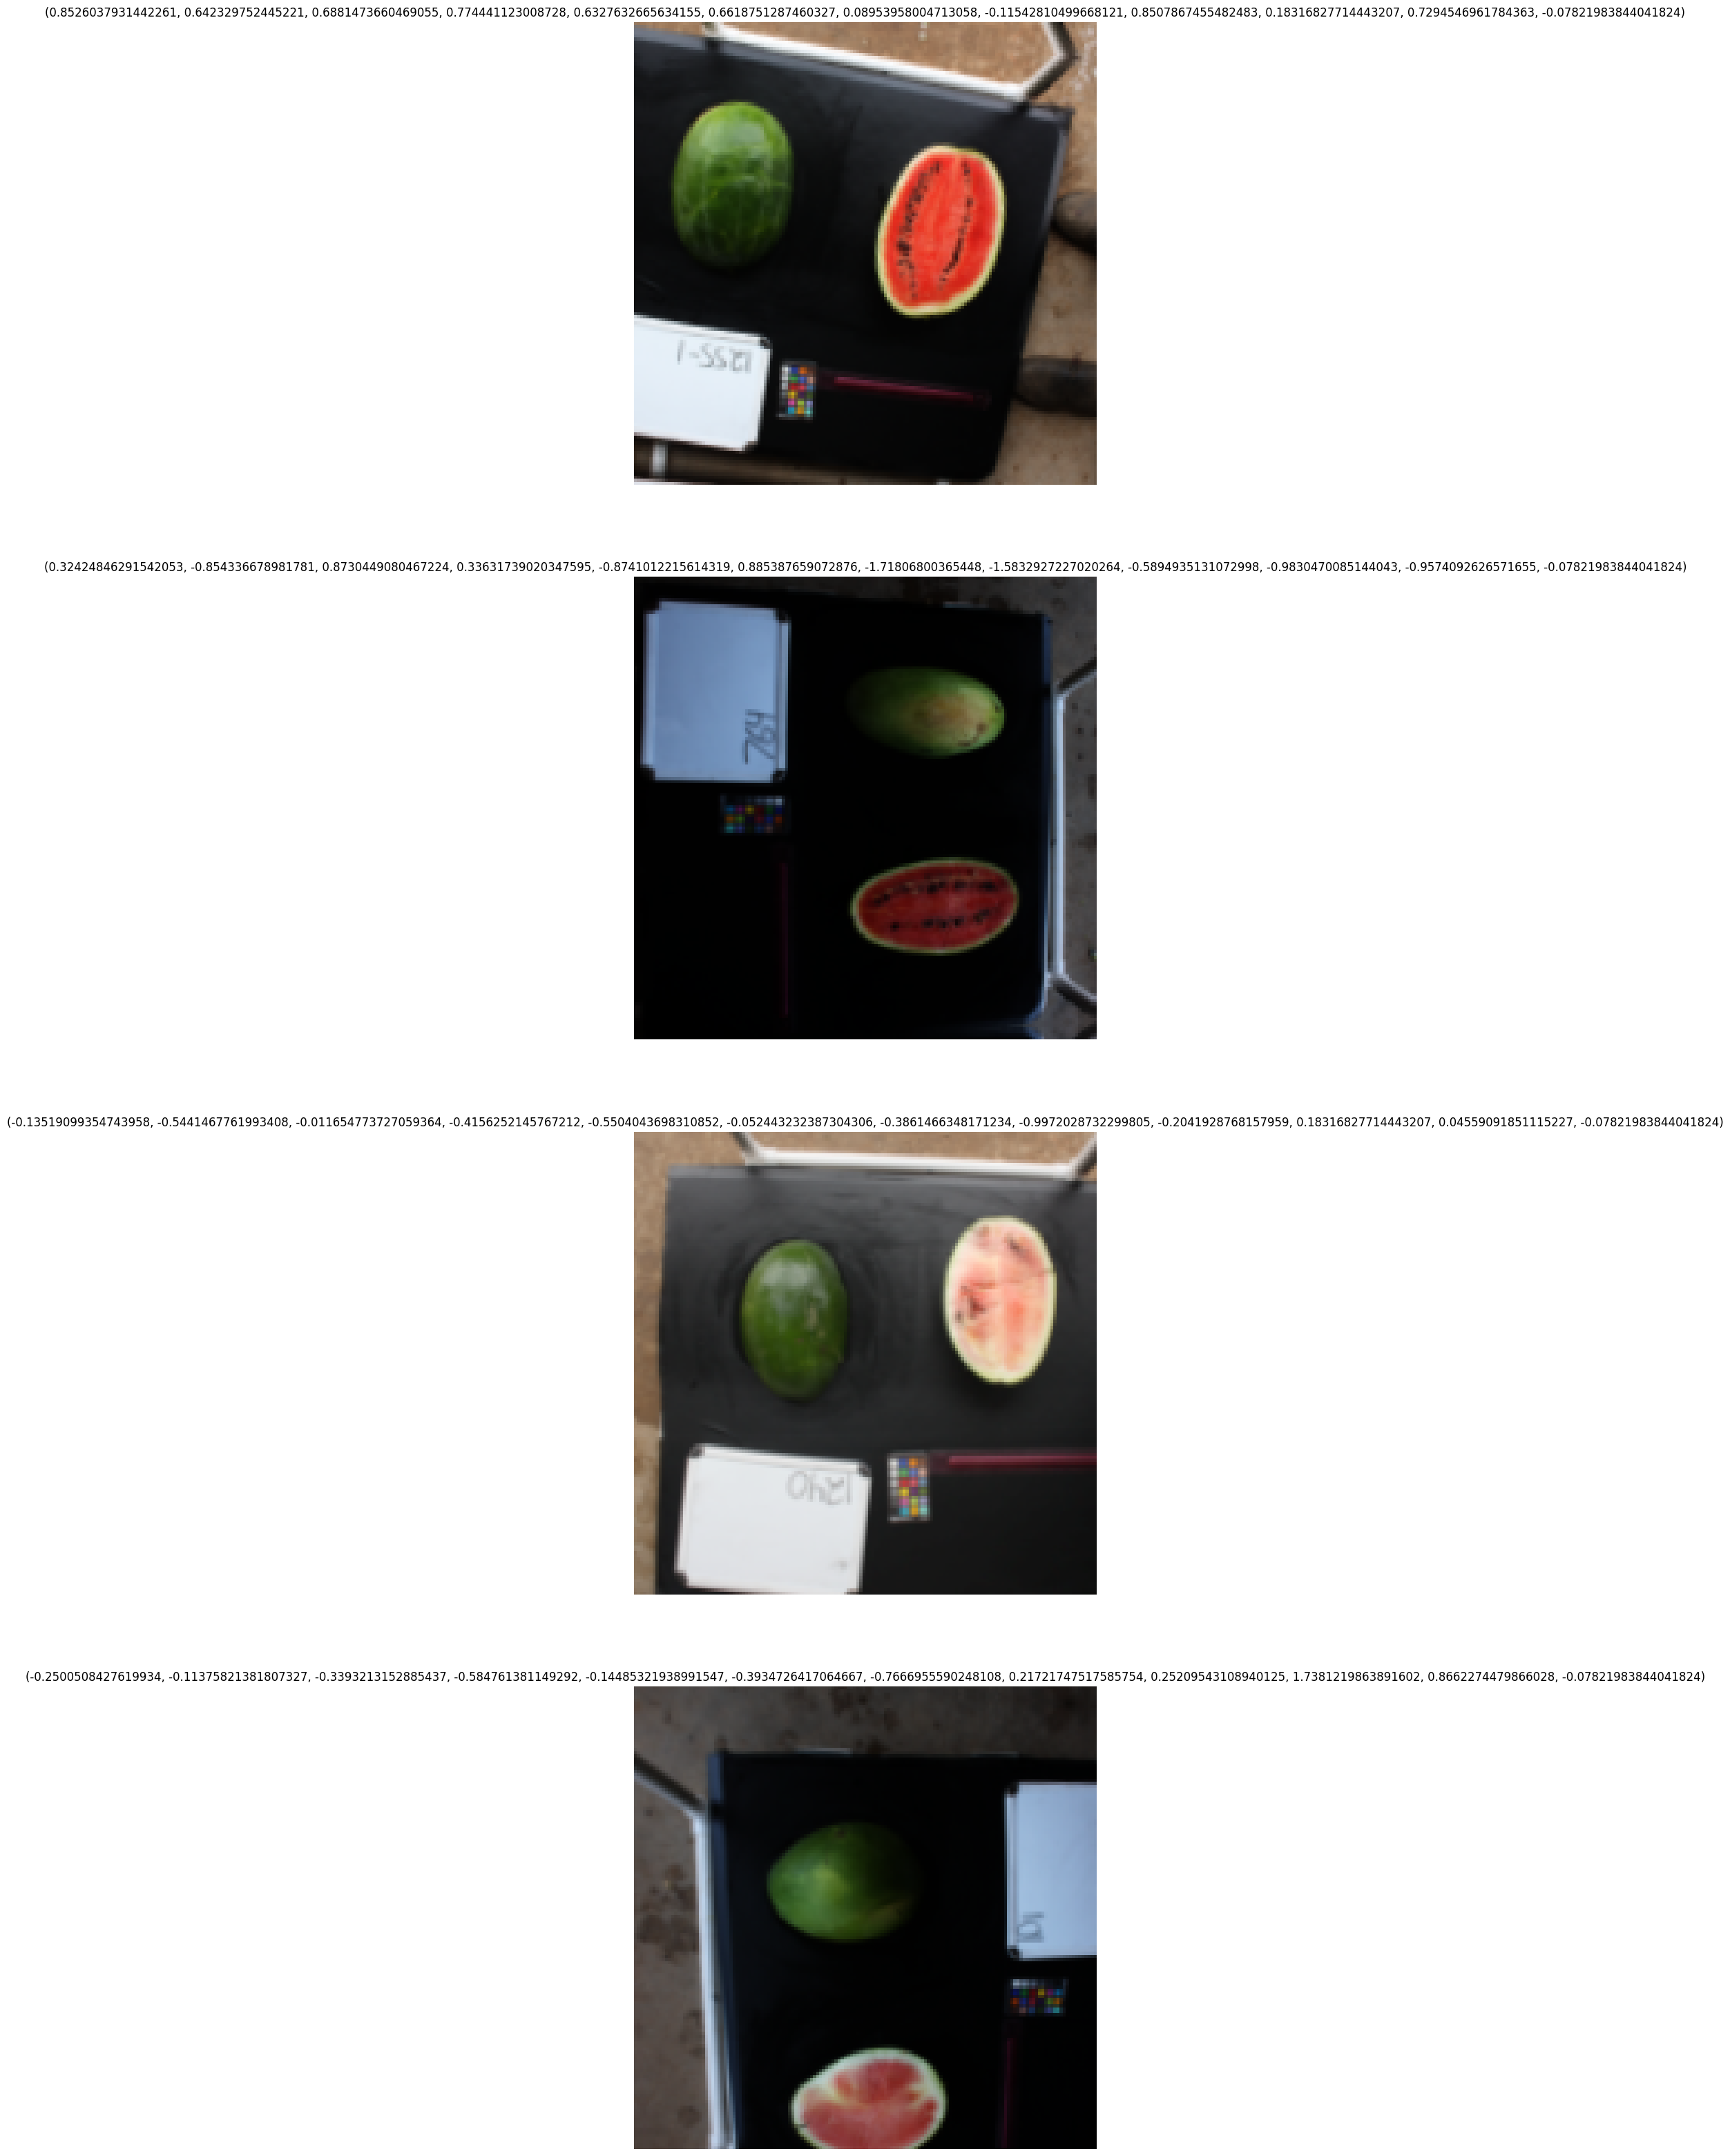

In [31]:
dls.show_batch(nrows=4, ncols=1, figsize=(40,40))

In [32]:
plant.summary(train)

Setting-up type transforms pipelines
58    580      6841       1.866367   1.379031    1.970728       1.935979   
21    478      6777       0.814650  -0.710874    1.598592       0.817235   
241   105      7389       0.279303   1.103737   -0.102933       0.236466   
75    796      6868      -0.047298   0.161535   -0.060805      -0.093655   
256   869      7412      -0.877286   0.192554   -1.106997      -0.985186   
..    ...       ...            ...        ...         ...            ...   
107   750      6930       1.146246  -0.187428    1.785830       1.219697   
49    805      6824      -0.301987  -1.079224    0.250478       0.158011   
76    630      6869      -0.963181  -0.610062   -0.814438      -0.970922   
89    870      6893       0.534991   0.398055    0.620274       0.581870   
113   743      6939       1.220155   0.355404    1.406673       1.339926   

     width2_cm  heigth2_cm  prox_angl_macr  distal_angl_macr  \
58    1.380614    1.832436       -0.107530         -0.928562  

    applying PILBase.create gives
      PILImage mode=RGB size=4272x2848
  Pipeline: ColReader -- {'cols': 'combined', 'pref': '', 'suff': '', 'label_delim': None} -> ToListTensor -- {} -> RegressionSetup -- {'c': 12}
    starting from
      line                                                                                                                                                                                                                                                                            361
photo_id                                                                                                                                                                                                                                                                       6927
perimeter1_cm                                                                                                                                                                                                 

Setting up Pipeline: ColReader -- {'cols': 'combined', 'pref': '', 'suff': '', 'label_delim': None} -> ToListTensor -- {} -> RegressionSetup -- {'c': 12}
Setting up after_item: Pipeline: Resize -- {'size': (150, 150), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Dihedral -- {'size': 150, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]]), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]]), 'axes': (0, 2, 3)}

Building one batch
Applying item_tfms to the first sample:
  Pipeline: Resize -- {'size': (150, 150), 'method': 'crop', 'pad_mode':

In [33]:
dls.c = n_out_val

In [34]:
dls.c

12

In [41]:
AllData.iloc[:, 2:14].max()

perimeter1_cm                2.866147
width1_cm                    3.348737
heigth1_cm                   3.339906
perimeter2_cm                3.140309
width2_cm                    3.386046
heigth2_cm                   3.387806
prox_angl_macr               2.182559
distal_angl_macr             1.621721
tomat_pericap_area           3.416607
tomat_pericap_area_ratio     2.904337
tomat_pericap_thick          3.009001
tomat_pericap_thick_ratio    7.613398
dtype: float64

In [42]:
AllData.iloc[:, 2:14].min()

perimeter1_cm               -2.721036
width1_cm                   -2.680580
heigth1_cm                  -3.725989
perimeter2_cm               -2.742776
width2_cm                   -2.719545
heigth2_cm                  -2.670074
prox_angl_macr              -2.601485
distal_angl_macr            -5.089271
tomat_pericap_area          -2.756328
tomat_pericap_area_ratio    -4.870431
tomat_pericap_thick         -3.601682
tomat_pericap_thick_ratio   -7.769838
dtype: float64

## Training

In [48]:
model = resnet50

In [49]:
learn = cnn_learner(
               dls, 
               model, 
               metrics = [ MSELossFlat(), mae, rmse, R2Score() ], 
               loss_func = L1LossFlat(),
               y_range=(-4.0,4.0),
)

/Users/user/opt/anaconda3/envs/py37_GANs_Torch/lib/python3.7/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/Users/user/opt/anaconda3/envs/py37_GANs_Torch/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/Users/user/opt/anaconda3/envs/py37_GANs_Torch/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAUL

In [50]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,None,mae,_rmse,r2_score,time
0,2.289122,2.270406,6.972994,2.270406,2.640643,-6.021658,01:05


epoch,train_loss,valid_loss,None,mae,_rmse,r2_score,time
0,2.209423,2.301380,7.034084,2.301380,2.652185,-6.083174,01:20
1,2.216283,2.081963,5.744962,2.081963,2.396865,-4.785056,01:19
2,2.219104,1.967748,5.228224,1.967748,2.286531,-4.264711,01:19


## Inference

In [119]:
test

,line,photo_id,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio,combined
175,919,7244,1.049364,1.731872,0.582826,0.838631,1.722915,0.307020,0.449702,1.003951,1.124047,0.183168,1.048591,-0.07822,"[1.0493637477048299, 1.7318718938827995, 0.582825956181605, 0.838631373438315, 1.7229145585442396, 0.3070202034052952, 0.4497019876740223, 1.0039506616796128, 1.1240465812407956, 0.18316827877113348, 1.04859109695097, -0.07821984063462172]"
140,565,7009,-0.000355,-0.249466,0.161540,0.028612,-0.260193,0.141114,-0.059962,0.037694,0.180252,0.183168,0.319136,-0.07822,"[-0.0003554984626328628, -0.24946631158422633, 0.16154039958363883, 0.028611881345265197, -0.26019345809280514, 0.1411140028168738, -0.0599618007332988, 0.03769446245382058, 0.18025247565080024, 0.18316827877113348, 0.31913642081116506, -0.07821984063462172]"
40,468,6805,-0.751439,0.068478,-0.889333,-0.752879,0.030017,-0.953406,0.945775,-5.089271,-1.229238,-1.760524,-1.367728,-0.07822,"[-0.7514391075187045, 0.06847837109345703, -0.8893330165968428, -0.752878622347023, 0.030017471171152946, -0.9534060705095133, 0.9457747417238128, -5.089271490815279, -1.2292379511840992, -1.7605238880448448, -1.367727517762135, -0.07821984063462172]"
84,607,6880,-0.202109,0.673349,-0.493793,-0.241395,0.643925,-0.587030,0.830251,1.241555,-0.250805,-0.205570,-0.182364,-0.07822,"[-0.20210934025694968, 0.6733487430168539, -0.49379268845764185, -0.24139461601908374, 0.6439252061526014, -0.5870298775434166, 0.830250949684821, 1.2415546450957915, -0.2508052762453098, -0.20557015459206263, -0.18236366903495146, -0.07821984063462172]"
234,1336,7373,0.255333,1.115369,-0.011655,0.351601,1.120169,-0.027096,-0.297805,0.903629,0.559139,0.183168,0.638273,-0.07822,"[0.25533253866283867, 1.1153693994224139, -0.011654773684413509, 0.3516007857396008, 1.1201687823806348, -0.027096450557496547, -0.2978049019900482, 0.903628979792783, 0.5591385551944049, 0.18316827877113348, 0.6382728416223291, -0.07821984063462172]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1184,7203,0.282300,-0.784544,0.777085,0.065292,-0.777364,0.751741,-1.391883,-1.863137,0.010908,0.183168,0.045591,-0.07822,"[0.2822996363284153, -0.7845439482856928, 0.7770854072795557, 0.06529200928910134, -0.7773642166529351, 0.7517409910937008, -1.3918831677710952, -1.8631374048756084, 0.010908358834471542, 0.18316827877113348, 0.045590917258737866, -0.07821984063462172]"
31,91,6791,-0.401866,0.180922,-0.622519,-0.371813,0.175123,-0.676896,1.598144,0.908909,-0.090442,0.183168,0.182364,-0.07822,"[-0.40186561926122416, 0.18092222228434468, -0.6225188307514642, -0.37181284870827924, 0.17512293580313198, -0.676895736195478, 1.5981443908851822, 0.9089090683131422, -0.09044152926014978, 0.18316827877113348, 0.18236366903495146, -0.07821984063462172]"
145,1042,7157,-1.011122,-0.978413,-0.915078,-1.124774,-0.996883,-0.985666,-0.053166,-0.601196,-0.643376,0.960645,-0.182364,-0.07822,"[-1.0111222702242622, -0.9784126572354997, -0.9150782450556073, -1.1247743639998058, -0.996882740070544, -0.9856656095128167, -0.053166283554533955, -0.6011962485096825, -0.6433757288649812, 0.9606451454975246, -0.18236366903495146, -0.07821984063462172]"
97,226,6909,0.196404,0.130516,0.187286,0.219145,0.123034,0.177982,-0.460897,0.354500,0.185384,0.183168,0.182364,-0.07822,"[0.19640443635657737, 0.13051635795739527, 0.1872856280424033, 0.21914476816463704, 0.12303379465319067, 0.17798204739207846, -0.4608973142803901, 0.3544997736753921, 0.18538411555432557, 0.18316827877113348, 0.18236366903495146, -0.07821984063462172]"


In [165]:
dl = learn.dls.test_dl(test)

In [166]:
probs, _ = learn.get_preds( dl=dl )

In [167]:
probs.shape

torch.Size([89, 12])

In [169]:
p1 = pd.DataFrame(
           probs
)

In [170]:
p1

,0,1,2,3,4,5,6,7,8,9,10,11
0,2.825243,3.121466,-0.776749,2.584027,3.147389,-0.351809,1.091099,3.615519,3.539556,2.617282,2.922629,1.492884
1,1.767699,2.049706,2.211968,3.811724,0.372404,1.785884,-0.108597,3.670871,3.206524,0.335481,3.604547,-1.079633
2,1.812142,2.026000,-3.783460,1.615732,-1.814163,1.645553,1.650375,3.744279,1.094038,0.366077,2.278782,2.195088
3,1.578764,2.818494,0.076325,2.709430,-0.247775,0.500200,0.045881,3.861473,0.921806,-0.425792,2.454295,2.079976
4,2.463579,3.588173,-1.144201,3.555922,1.311271,-1.168586,1.407937,3.717538,3.643579,3.069571,3.567244,-0.675248
...,...,...,...,...,...,...,...,...,...,...,...,...
84,-0.698916,2.914169,-1.667677,3.459532,-2.056886,2.101192,-3.143562,1.608331,3.769066,-1.456310,2.729460,2.522984
85,0.234136,3.361107,-2.588665,1.492455,-0.873128,-1.558953,-0.270950,3.228089,2.375071,-0.365596,2.037730,2.594499
86,-2.712875,1.883449,-0.769346,1.926912,0.217548,-1.250387,0.006685,1.592735,3.298574,0.567099,2.499360,1.834765
87,-1.629654,2.841686,-1.900100,2.804130,1.720298,-1.341245,2.264699,3.916127,1.160841,-0.261211,2.312662,3.337339


## De-standardize pandas data frame

In [171]:
p1_np = p1.to_numpy()

In [172]:
p1_np

array([[ 2.8252425 ,  3.1214662 , -0.7767494 , ...,  2.6172824 ,
         2.9226294 ,  1.4928837 ],
       [ 1.7676992 ,  2.0497055 ,  2.211968  , ...,  0.3354807 ,
         3.604547  , -1.0796325 ],
       [ 1.8121419 ,  2.0259995 , -3.7834601 , ...,  0.36607742,
         2.278782  ,  2.1950884 ],
       ...,
       [-2.712875  ,  1.8834491 , -0.769346  , ...,  0.5670986 ,
         2.49936   ,  1.834765  ],
       [-1.6296542 ,  2.8416858 , -1.9000995 , ..., -0.2612114 ,
         2.3126621 ,  3.337339  ],
       [ 1.2174559 ,  3.0848203 ,  1.06637   , ...,  1.5907512 ,
         1.9080687 , -0.23846316]], dtype=float32)

In [173]:

y_deviations_np = y_deviations.to_numpy()

y_deviations_np

array([1.00122009e+01, 2.57906499e+00, 4.27263639e+00, 9.81457863e+00,
       2.68770029e+00, 4.33980163e+00, 1.47155834e+01, 1.89390764e+01,
       2.33843376e+01, 2.57242381e-02, 2.19341935e-01, 1.30011663e-03])

In [174]:
y_means_np = y_means.to_numpy()

y_means_np

array([ 75.75355932,  18.55338983,  25.25979661,  79.70918644,
        19.53932203,  26.71759322, 124.68237288, 123.68610169,
        79.05491525,   0.18528814,   1.02      ,   0.20010169])

In [175]:
p1_np.shape

(89, 12)

In [156]:

## p1.astype(float)
## p1.iloc[:, 0:12] = (  p1.iloc[:, 0:12] * y_deviations   ) + y_means
## p1 = (p1 * y_deviations) + y_means


In [176]:
p1_np = (  p1_np * y_deviations_np ) + y_means_np

In [177]:
p1_np.shape

(89, 12)

In [178]:
p1_np

array([[104.04045507,  26.60385392,  21.94102897, ...,   0.25261573,
          1.66105518,   0.20204262],
       [ 93.45211929,  23.83971354,  34.71073135, ...,   0.19391812,
          1.81062832,   0.19869805],
       [ 93.89708807,  23.77857433,   9.09444713, ...,   0.1947052 ,
          1.51983243,   0.20295557],
       ...,
       [ 48.59171086,  23.41092741,  21.9726609 , ...,   0.19987632,
          1.56821448,   0.2024871 ],
       [ 59.43713435,  25.88228212,  17.14136227, ...,   0.17856867,
          1.52726378,   0.20444062],
       [ 87.94297204,  26.50934179,  29.81600792, ...,   0.226209  ,
          1.43851947,   0.19979166]])

In [181]:
p1 = pd.DataFrame(
           p1_np, 
           columns=[ list_of_traits ]
)

In [183]:
p1

,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio
0,104.040455,26.603854,21.941029,105.070321,27.998560,25.190811,140.738535,192.160684,161.825088,0.252616,1.661055,0.202043
1,93.452119,23.839714,34.710731,117.119649,20.540233,34.467975,123.084304,193.209013,154.037353,0.193918,1.810628,0.198698
2,93.897088,23.778574,9.094447,95.566917,14.663395,33.858965,148.968609,194.599286,104.638281,0.194705,1.519832,0.202956
3,91.560466,25.822470,25.585905,106.301102,18.873378,28.888363,125.357543,196.818826,100.610735,0.174335,1.558330,0.202806
4,100.419404,27.807522,20.371042,114.609063,23.063625,21.646161,145.400981,194.092845,164.257597,0.264251,1.802446,0.199224
...,...,...,...,...,...,...,...,...,...,...,...,...
84,68.755870,26.069222,18.134418,113.663033,14.011028,35.836352,78.423019,154.146400,167.192024,0.147826,1.618685,0.203382
85,78.097772,27.221903,14.199370,94.356999,17.192616,19.952048,120.695181,184.823123,134.594367,0.175883,1.466960,0.203475
86,48.591711,23.410927,21.972661,98.621019,20.124026,21.291163,124.780750,153.851037,156.189883,0.199876,1.568214,0.202487
87,59.437134,25.882282,17.141362,107.230537,24.162968,20.896856,158.008740,197.853934,106.200413,0.178569,1.527264,0.204441


In [189]:
the_list = test["photo_id"].tolist()
the_list

[7244,
 7009,
 6805,
 6880,
 7373,
 6765,
 7327,
 6853,
 6834,
 6989,
 7423,
 7394,
 7271,
 7289,
 6815,
 7410,
 6838,
 6744,
 6916,
 7437,
 6771,
 7275,
 6988,
 7167,
 6936,
 6781,
 7451,
 7294,
 6763,
 7303,
 6861,
 7005,
 6943,
 6753,
 7000,
 6995,
 7446,
 6911,
 6833,
 7435,
 7409,
 7722,
 6760,
 7422,
 6903,
 7220,
 7332,
 6742,
 6960,
 7223,
 7163,
 6917,
 7164,
 6848,
 6862,
 7416,
 6966,
 6874,
 7221,
 7399,
 7248,
 6875,
 7264,
 6784,
 6950,
 6879,
 6958,
 7291,
 6748,
 6817,
 7261,
 6775,
 6783,
 6810,
 6991,
 7191,
 7311,
 6926,
 6970,
 6919,
 6757,
 6794,
 7402,
 7255,
 7203,
 6791,
 7157,
 6909,
 7335]

In [190]:
len(set(the_list))

89

In [191]:
p1['photo_id'] = test["photo_id"].tolist()

In [192]:


cols = ['photo_id', 'perimeter1_cm','width1_cm','heigth1_cm','perimeter2_cm','width2_cm', 
        'heigth2_cm','prox_angl_macr','distal_angl_macr','tomat_pericap_area', 
        'tomat_pericap_area_ratio', 'tomat_pericap_thick','tomat_pericap_thick_ratio' ]

In [193]:
p1[cols]

,photo_id,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio
0,7244,104.040455,26.603854,21.941029,105.070321,27.998560,25.190811,140.738535,192.160684,161.825088,0.252616,1.661055,0.202043
1,7009,93.452119,23.839714,34.710731,117.119649,20.540233,34.467975,123.084304,193.209013,154.037353,0.193918,1.810628,0.198698
2,6805,93.897088,23.778574,9.094447,95.566917,14.663395,33.858965,148.968609,194.599286,104.638281,0.194705,1.519832,0.202956
3,6880,91.560466,25.822470,25.585905,106.301102,18.873378,28.888363,125.357543,196.818826,100.610735,0.174335,1.558330,0.202806
4,7373,100.419404,27.807522,20.371042,114.609063,23.063625,21.646161,145.400981,194.092845,164.257597,0.264251,1.802446,0.199224
...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,7203,68.755870,26.069222,18.134418,113.663033,14.011028,35.836352,78.423019,154.146400,167.192024,0.147826,1.618685,0.203382
85,6791,78.097772,27.221903,14.199370,94.356999,17.192616,19.952048,120.695181,184.823123,134.594367,0.175883,1.466960,0.203475
86,7157,48.591711,23.410927,21.972661,98.621019,20.124026,21.291163,124.780750,153.851037,156.189883,0.199876,1.568214,0.202487
87,6909,59.437134,25.882282,17.141362,107.230537,24.162968,20.896856,158.008740,197.853934,106.200413,0.178569,1.527264,0.204441


In [194]:
p1

,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio,photo_id
0,104.040455,26.603854,21.941029,105.070321,27.998560,25.190811,140.738535,192.160684,161.825088,0.252616,1.661055,0.202043,7244
1,93.452119,23.839714,34.710731,117.119649,20.540233,34.467975,123.084304,193.209013,154.037353,0.193918,1.810628,0.198698,7009
2,93.897088,23.778574,9.094447,95.566917,14.663395,33.858965,148.968609,194.599286,104.638281,0.194705,1.519832,0.202956,6805
3,91.560466,25.822470,25.585905,106.301102,18.873378,28.888363,125.357543,196.818826,100.610735,0.174335,1.558330,0.202806,6880
4,100.419404,27.807522,20.371042,114.609063,23.063625,21.646161,145.400981,194.092845,164.257597,0.264251,1.802446,0.199224,7373
...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,68.755870,26.069222,18.134418,113.663033,14.011028,35.836352,78.423019,154.146400,167.192024,0.147826,1.618685,0.203382,7203
85,78.097772,27.221903,14.199370,94.356999,17.192616,19.952048,120.695181,184.823123,134.594367,0.175883,1.466960,0.203475,6791
86,48.591711,23.410927,21.972661,98.621019,20.124026,21.291163,124.780750,153.851037,156.189883,0.199876,1.568214,0.202487,7157
87,59.437134,25.882282,17.141362,107.230537,24.162968,20.896856,158.008740,197.853934,106.200413,0.178569,1.527264,0.204441,6909


In [204]:
test

,line,photo_id,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio,combined
175,919,7244,1.049364,1.731872,0.582826,0.838631,1.722915,0.307020,0.449702,1.003951,1.124047,0.183168,1.048591,-0.07822,"[1.0493637477048299, 1.7318718938827995, 0.582825956181605, 0.838631373438315, 1.7229145585442396, 0.3070202034052952, 0.4497019876740223, 1.0039506616796128, 1.1240465812407956, 0.18316827877113348, 1.04859109695097, -0.07821984063462172]"
140,565,7009,-0.000355,-0.249466,0.161540,0.028612,-0.260193,0.141114,-0.059962,0.037694,0.180252,0.183168,0.319136,-0.07822,"[-0.0003554984626328628, -0.24946631158422633, 0.16154039958363883, 0.028611881345265197, -0.26019345809280514, 0.1411140028168738, -0.0599618007332988, 0.03769446245382058, 0.18025247565080024, 0.18316827877113348, 0.31913642081116506, -0.07821984063462172]"
40,468,6805,-0.751439,0.068478,-0.889333,-0.752879,0.030017,-0.953406,0.945775,-5.089271,-1.229238,-1.760524,-1.367728,-0.07822,"[-0.7514391075187045, 0.06847837109345703, -0.8893330165968428, -0.752878622347023, 0.030017471171152946, -0.9534060705095133, 0.9457747417238128, -5.089271490815279, -1.2292379511840992, -1.7605238880448448, -1.367727517762135, -0.07821984063462172]"
84,607,6880,-0.202109,0.673349,-0.493793,-0.241395,0.643925,-0.587030,0.830251,1.241555,-0.250805,-0.205570,-0.182364,-0.07822,"[-0.20210934025694968, 0.6733487430168539, -0.49379268845764185, -0.24139461601908374, 0.6439252061526014, -0.5870298775434166, 0.830250949684821, 1.2415546450957915, -0.2508052762453098, -0.20557015459206263, -0.18236366903495146, -0.07821984063462172]"
234,1336,7373,0.255333,1.115369,-0.011655,0.351601,1.120169,-0.027096,-0.297805,0.903629,0.559139,0.183168,0.638273,-0.07822,"[0.25533253866283867, 1.1153693994224139, -0.011654773684413509, 0.3516007857396008, 1.1201687823806348, -0.027096450557496547, -0.2978049019900482, 0.903628979792783, 0.5591385551944049, 0.18316827877113348, 0.6382728416223291, -0.07821984063462172]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1184,7203,0.282300,-0.784544,0.777085,0.065292,-0.777364,0.751741,-1.391883,-1.863137,0.010908,0.183168,0.045591,-0.07822,"[0.2822996363284153, -0.7845439482856928, 0.7770854072795557, 0.06529200928910134, -0.7773642166529351, 0.7517409910937008, -1.3918831677710952, -1.8631374048756084, 0.010908358834471542, 0.18316827877113348, 0.045590917258737866, -0.07821984063462172]"
31,91,6791,-0.401866,0.180922,-0.622519,-0.371813,0.175123,-0.676896,1.598144,0.908909,-0.090442,0.183168,0.182364,-0.07822,"[-0.40186561926122416, 0.18092222228434468, -0.6225188307514642, -0.37181284870827924, 0.17512293580313198, -0.676895736195478, 1.5981443908851822, 0.9089090683131422, -0.09044152926014978, 0.18316827877113348, 0.18236366903495146, -0.07821984063462172]"
145,1042,7157,-1.011122,-0.978413,-0.915078,-1.124774,-0.996883,-0.985666,-0.053166,-0.601196,-0.643376,0.960645,-0.182364,-0.07822,"[-1.0111222702242622, -0.9784126572354997, -0.9150782450556073, -1.1247743639998058, -0.996882740070544, -0.9856656095128167, -0.053166283554533955, -0.6011962485096825, -0.6433757288649812, 0.9606451454975246, -0.18236366903495146, -0.07821984063462172]"
97,226,6909,0.196404,0.130516,0.187286,0.219145,0.123034,0.177982,-0.460897,0.354500,0.185384,0.183168,0.182364,-0.07822,"[0.19640443635657737, 0.13051635795739527, 0.1872856280424033, 0.21914476816463704, 0.12303379465319067, 0.17798204739207846, -0.4608973142803901, 0.3544997736753921, 0.18538411555432557, 0.18316827877113348, 0.18236366903495146, -0.07821984063462172]"


## load test in dataframe to concatenate with p1 pred and compare

In [206]:
test = test.drop(['line', 'photo_id', 'combined'], axis=1)

In [207]:
test

,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio
175,1.049364,1.731872,0.582826,0.838631,1.722915,0.307020,0.449702,1.003951,1.124047,0.183168,1.048591,-0.07822
140,-0.000355,-0.249466,0.161540,0.028612,-0.260193,0.141114,-0.059962,0.037694,0.180252,0.183168,0.319136,-0.07822
40,-0.751439,0.068478,-0.889333,-0.752879,0.030017,-0.953406,0.945775,-5.089271,-1.229238,-1.760524,-1.367728,-0.07822
84,-0.202109,0.673349,-0.493793,-0.241395,0.643925,-0.587030,0.830251,1.241555,-0.250805,-0.205570,-0.182364,-0.07822
234,0.255333,1.115369,-0.011655,0.351601,1.120169,-0.027096,-0.297805,0.903629,0.559139,0.183168,0.638273,-0.07822
...,...,...,...,...,...,...,...,...,...,...,...,...
163,0.282300,-0.784544,0.777085,0.065292,-0.777364,0.751741,-1.391883,-1.863137,0.010908,0.183168,0.045591,-0.07822
31,-0.401866,0.180922,-0.622519,-0.371813,0.175123,-0.676896,1.598144,0.908909,-0.090442,0.183168,0.182364,-0.07822
145,-1.011122,-0.978413,-0.915078,-1.124774,-0.996883,-0.985666,-0.053166,-0.601196,-0.643376,0.960645,-0.182364,-0.07822
97,0.196404,0.130516,0.187286,0.219145,0.123034,0.177982,-0.460897,0.354500,0.185384,0.183168,0.182364,-0.07822


In [208]:
test_np = test.to_numpy()

In [209]:
test_np = (  test_np * y_deviations_np ) + y_means_np

In [210]:
test_np.shape

(89, 12)

In [211]:
test_df = pd.DataFrame(
           test_np, 
           columns=[ list_of_traits ]
)

In [212]:
test_df

,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio
0,86.26,23.02,27.75,87.94,24.17,28.05,131.3,142.7,105.34,0.19,1.25,0.2
1,75.75,17.91,25.95,79.99,18.84,27.33,123.8,124.4,83.27,0.19,1.09,0.2
2,68.23,18.73,21.46,72.32,19.62,22.58,138.6,27.3,50.31,0.14,0.72,0.2
3,73.73,20.29,23.15,77.34,21.27,24.17,136.9,147.2,73.19,0.18,0.98,0.2
4,78.31,21.43,25.21,83.16,22.55,26.60,120.3,140.8,92.13,0.19,1.16,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...
84,78.58,16.53,28.58,80.35,17.45,29.98,104.2,88.4,79.31,0.19,1.03,0.2
85,71.73,19.02,22.60,76.06,20.01,23.78,148.2,140.9,76.94,0.19,1.06,0.2
86,65.63,16.03,21.35,68.67,16.86,22.44,123.9,112.3,64.01,0.21,0.98,0.2
87,77.72,18.89,26.06,81.86,19.87,27.49,117.9,130.4,83.39,0.19,1.06,0.2


In [213]:
test_df['photo_id'] = the_list

In [ ]:
cols = ['photo_id', 'perimeter1_cm','width1_cm','heigth1_cm','perimeter2_cm','width2_cm', 
        'heigth2_cm','prox_angl_macr','distal_angl_macr','tomat_pericap_area', 
        'tomat_pericap_area_ratio', 'tomat_pericap_thick','tomat_pericap_thick_ratio' ]



In [214]:
test_df[cols]

,photo_id,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio
0,7244,86.26,23.02,27.75,87.94,24.17,28.05,131.3,142.7,105.34,0.19,1.25,0.2
1,7009,75.75,17.91,25.95,79.99,18.84,27.33,123.8,124.4,83.27,0.19,1.09,0.2
2,6805,68.23,18.73,21.46,72.32,19.62,22.58,138.6,27.3,50.31,0.14,0.72,0.2
3,6880,73.73,20.29,23.15,77.34,21.27,24.17,136.9,147.2,73.19,0.18,0.98,0.2
4,7373,78.31,21.43,25.21,83.16,22.55,26.60,120.3,140.8,92.13,0.19,1.16,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,7203,78.58,16.53,28.58,80.35,17.45,29.98,104.2,88.4,79.31,0.19,1.03,0.2
85,6791,71.73,19.02,22.60,76.06,20.01,23.78,148.2,140.9,76.94,0.19,1.06,0.2
86,7157,65.63,16.03,21.35,68.67,16.86,22.44,123.9,112.3,64.01,0.21,0.98,0.2
87,6909,77.72,18.89,26.06,81.86,19.87,27.49,117.9,130.4,83.39,0.19,1.06,0.2


In [215]:
test_df

,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio,photo_id
0,86.26,23.02,27.75,87.94,24.17,28.05,131.3,142.7,105.34,0.19,1.25,0.2,7244
1,75.75,17.91,25.95,79.99,18.84,27.33,123.8,124.4,83.27,0.19,1.09,0.2,7009
2,68.23,18.73,21.46,72.32,19.62,22.58,138.6,27.3,50.31,0.14,0.72,0.2,6805
3,73.73,20.29,23.15,77.34,21.27,24.17,136.9,147.2,73.19,0.18,0.98,0.2,6880
4,78.31,21.43,25.21,83.16,22.55,26.60,120.3,140.8,92.13,0.19,1.16,0.2,7373
...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,78.58,16.53,28.58,80.35,17.45,29.98,104.2,88.4,79.31,0.19,1.03,0.2,7203
85,71.73,19.02,22.60,76.06,20.01,23.78,148.2,140.9,76.94,0.19,1.06,0.2,6791
86,65.63,16.03,21.35,68.67,16.86,22.44,123.9,112.3,64.01,0.21,0.98,0.2,7157
87,77.72,18.89,26.06,81.86,19.87,27.49,117.9,130.4,83.39,0.19,1.06,0.2,6909


In [233]:
new_p1_np   = p1.to_numpy() 
new_test_np = test_df.to_numpy()

In [235]:
combined_np = np.concatenate((new_p1_np, new_test_np), axis=0)

In [236]:
combined_np

array([[1.04040455e+02, 2.66038539e+01, 2.19410290e+01, ...,
        1.66105518e+00, 2.02042618e-01, 7.24400000e+03],
       [9.34521193e+01, 2.38397135e+01, 3.47107313e+01, ...,
        1.81062832e+00, 1.98698047e-01, 7.00900000e+03],
       [9.38970881e+01, 2.37785743e+01, 9.09444713e+00, ...,
        1.51983243e+00, 2.02955566e-01, 6.80500000e+03],
       ...,
       [6.56300000e+01, 1.60300000e+01, 2.13500000e+01, ...,
        9.80000000e-01, 2.00000000e-01, 7.15700000e+03],
       [7.77200000e+01, 1.88900000e+01, 2.60600000e+01, ...,
        1.06000000e+00, 2.00000000e-01, 6.90900000e+03],
       [8.31400000e+01, 2.13300000e+01, 2.61100000e+01, ...,
        1.31000000e+00, 2.00000000e-01, 7.33500000e+03]])

In [237]:
combined_np.shape

(178, 13)

In [239]:

list_of_traits_r = [ 'perimeter1_cm','width1_cm','heigth1_cm','perimeter2_cm','width2_cm', 
                  'heigth2_cm','prox_angl_macr','distal_angl_macr','tomat_pericap_area', 
                  'tomat_pericap_area_ratio', 'tomat_pericap_thick','tomat_pericap_thick_ratio', 'photo_id' ]

combined_pred_test_df = pd.DataFrame(
                                combined_np, 
                                columns=[ list_of_traits_r ]
)

In [240]:
combined_pred_test_df

,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio,photo_id
0,104.040455,26.603854,21.941029,105.070321,27.998560,25.190811,140.738535,192.160684,161.825088,0.252616,1.661055,0.202043,7244.0
1,93.452119,23.839714,34.710731,117.119649,20.540233,34.467975,123.084304,193.209013,154.037353,0.193918,1.810628,0.198698,7009.0
2,93.897088,23.778574,9.094447,95.566917,14.663395,33.858965,148.968609,194.599286,104.638281,0.194705,1.519832,0.202956,6805.0
3,91.560466,25.822470,25.585905,106.301102,18.873378,28.888363,125.357543,196.818826,100.610735,0.174335,1.558330,0.202806,6880.0
4,100.419404,27.807522,20.371042,114.609063,23.063625,21.646161,145.400981,194.092845,164.257597,0.264251,1.802446,0.199224,7373.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,78.580000,16.530000,28.580000,80.350000,17.450000,29.980000,104.200000,88.400000,79.310000,0.190000,1.030000,0.200000,7203.0
174,71.730000,19.020000,22.600000,76.060000,20.010000,23.780000,148.200000,140.900000,76.940000,0.190000,1.060000,0.200000,6791.0
175,65.630000,16.030000,21.350000,68.670000,16.860000,22.440000,123.900000,112.300000,64.010000,0.210000,0.980000,0.200000,7157.0
176,77.720000,18.890000,26.060000,81.860000,19.870000,27.490000,117.900000,130.400000,83.390000,0.190000,1.060000,0.200000,6909.0


In [244]:
combined_pred_test_df.to_csv('preds_vs_real.watermelon.csv') 